In [1]:
#langgraph using tools and agents in groq 

In [2]:
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun,DuckDuckGoSearchRun
from langchain_groq import ChatGroq
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph,START,END
import os
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
arxiv_api=ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=300)
arxiv_tool=ArxivQueryRun(api_wrapper=arxiv_api)

In [4]:
arxiv_tool.name

'arxiv'

In [5]:
wiki_api=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=300)
wiki_tool=WikipediaQueryRun(api_wrapper=wiki_api)

In [6]:
wiki_tool.name

'wikipedia'

In [7]:
search=DuckDuckGoSearchRun(name="search")

In [8]:
search.name

'search'

In [9]:
wiki_tool.invoke("what is gen ai")

'Page: Generative artificial intelligence\nSummary: Generative artificial intelligence (generative AI, GenAI, or GAI) is a subset of artificial intelligence that uses generative models to produce text, images, videos, or other forms of data. These models learn the underlying patterns and structures of'

In [10]:
tools=[search,wiki_tool,arxiv_tool]

In [11]:
#State
#If you want to keep track of a specific information, you should use State.
#State information is available to all the nodes and the information in the state can be updated by the nodes.

In [12]:
class State(TypedDict):
    messages:Annotated[list,add_messages]

In [13]:
graph_builder=StateGraph(State)

In [14]:
graph_builder

In [15]:
groq_api_key=os.getenv("GROQ_API_KEY")

In [16]:
llm=ChatGroq(model="gemma2-9b-it",api_key=groq_api_key)

In [17]:
llm_tools=llm.bind_tools(tools=tools)

In [18]:
def chatbot(state:State):
    return ({"messages":[llm_tools.invoke(state["messages"])]})

In [19]:
graph_builder.add_node("chatbot",chatbot)

In [20]:
graph_builder.add_edge(START,"chatbot")

In [21]:
from langgraph.prebuilt import ToolNode,tools_condition

In [22]:
tool_node=ToolNode(tools=tools)

In [23]:
graph_builder.add_node("tools",tool_node)

In [24]:
#Simples Edges are direct connection between nodes, where the output of the first node is fed into the subesquent node as input.

#Conditional Edges determine the destination based on the outcome of the condition.

In [25]:
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)

In [26]:
graph_builder.add_edge("tools","chatbot")

In [27]:
graph_builder.add_edge("chatbot",END)

In [28]:
graph=graph_builder.compile()

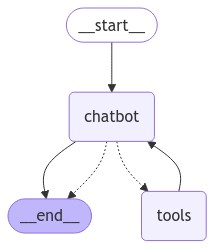

In [29]:
from IPython.display import Image,display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    pass



In [30]:
userinput="what is deep learning"

In [31]:
events=graph.stream(
    {"messages":[("user",userinput)]},stream_mode="values"
)

In [32]:
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is deep learning
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_pfyc)
 Call ID: call_pfyc
  Args:
    query: deep learning
================================= Tool Message =================================
Name: wikipedia

Page: Deep learning
Summary: Deep learning is a subset of machine learning that focuses on utilizing neural networks to perform tasks such as classification, regression, and representation learning. The field takes inspiration from biological neuroscience and is centered around stacking artificial n
================================== Ai Message ==================================

Deep learning is a subset of machine learning that focuses on utilizing neural networks to perform tasks such as classification, regression, and representation learning. The field takes inspiration from biological neuroscience and is centered ar